In [147]:
import numpy as np
import scipy
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Own implementation

In [148]:
# Get the square of l2 norm
def l2(X, Y):
    l2_arr = np.empty([X.shape[0], Y.shape[0]])
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            diff = X[i,:]-Y[j,:]
            l2_arr[i, j] = np.dot(diff, diff)
    return l2_arr

# Get rbf kernel
def rbf_kernel(X, Y=None, gamma=None):
    '''
    Compute the rbf (gaussian) kernel between X and Y.

        K(x, y) = exp(-gamma ||x-y||^2)

    for each pair of rows x in X and y in Y.
    '''
    if Y is None:
        Y = X
    K = np.exp(-1*gamma*l2(X, Y))
    return K

# Center the kernel matrix
def center_kernel(K):
    n_samples = K.shape[0]
    K_fit_rows = np.sum(K, axis=0) / n_samples
    K_fit_all = K_fit_rows.sum() / n_samples
    K_pred_cols = (np.sum(K, axis=1) / K_fit_rows.shape[0])[:, np.newaxis]
    K -= K_fit_rows
    K -= K_pred_cols
    K += K_fit_all
    return K

def kernel_PCA(X, n_components=None, kernel='rbf', gamma=None):
    if kernel == 'rbf':
        K = rbf_kernel(X, gamma = gamma)
        K = center_kernel(K)
    if n_components is None:
        n_components = K.shape[0]

    # Solve for eigenvalues and eigenvectors, subset_by_index specifies the indices of smallest/largest to return
    eigenvalues, eigenvectors = scipy.linalg.eigh(K, subset_by_index=(K.shape[0] - n_components, K.shape[0]-1))

    # Get indices of eigenvalues from largest to smallest
    indices = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]
    eigenvectors = eigenvectors[:, eigenvalues > 0]
    eigenvalues = eigenvalues[eigenvalues > 0]
    # You are supposed to find eigenvectors of K and then multiply them by K, multiplying a matrix and its eigenvector results in the same eigenvector scaled by the eigenvalue (by definition).
    X_transformed = eigenvectors * np.sqrt(eigenvalues)
    return X_transformed, eigenvectors, eigenvalues

Text(0.5, 1.0, 'data')

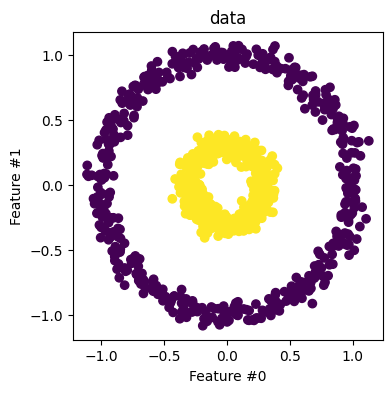

In [149]:
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
_, ax = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(4, 4))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_ylabel("Feature #1")
ax.set_xlabel("Feature #0")
ax.set_title("data")

In [150]:
X_kernel_pca, eigenvectors, eigenvalues = kernel_PCA(X, n_components=None, kernel='rbf', gamma=10)

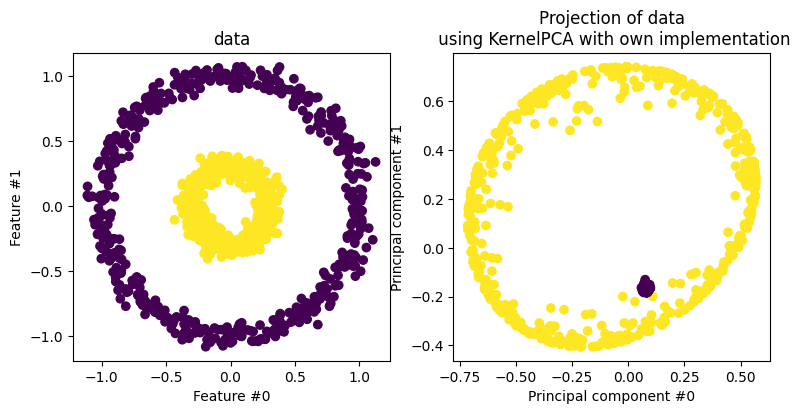

In [151]:
fig, (orig_data_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=2, figsize=(9, 4)
)

orig_data_ax.scatter(X[:, 0], X[:, 1], c=y)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("data")

kernel_pca_proj_ax.scatter(X_kernel_pca[:, 0], X_kernel_pca[:, 1], c=y)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of data\n using KernelPCA with own implementation")

# Compare to the results taken from sklearn example
https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py

In [152]:
from sklearn.decomposition import KernelPCA
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, eigen_solver='dense'
)
X_kernel_pca_sklearn = kernel_pca.fit(X).transform(X)

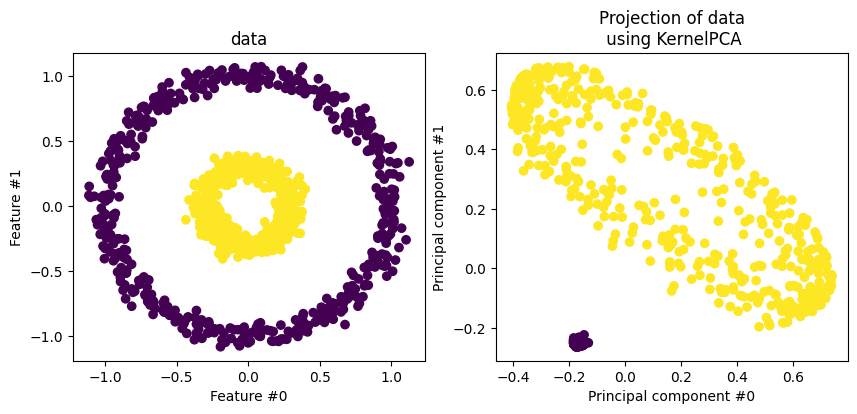

In [153]:
fig, (orig_data_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=2, figsize=(10, 4)
)

orig_data_ax.scatter(X[:, 0], X[:, 1], c=y)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("data")

kernel_pca_proj_ax.scatter(X_kernel_pca_sklearn[:, 1], X_kernel_pca_sklearn[:, 2], c=y)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of data\n using KernelPCA")

Note that we get the same magnitude in each PC's for both our own implementation and sklearn example, but sometimes the signs are flipped as you can see from the two plots. Each PC is an eigenvector of K, the sign being flipped does not make a difference. Below we visualize the PC's (eigenvectors) of our own implementation vs sklearn.

In [154]:
print(f"Own implementation\n{eigenvectors}")
print(f"sklearn\n{kernel_pca.eigenvectors_}")

Own implementation
[[-0.04874267  0.05159269  0.01251619 ...  0.          0.
   0.        ]
 [-0.05024189 -0.02272287 -0.04860843 ... -0.00615905  0.00162926
  -0.00062835]
 [ 0.00814747 -0.01736404  0.02535501 ... -0.00335556 -0.00096022
   0.00172684]
 ...
 [ 0.03208536  0.05881071 -0.02289995 ... -0.02185215 -0.00587783
  -0.00156721]
 [-0.01418666  0.06905899  0.012249   ... -0.00455318 -0.00428381
   0.01390451]
 [ 0.05492013  0.01817501 -0.04563389 ... -0.02463856  0.04000384
   0.03402352]]
sklearn
[[ 0.04874267  0.05159269 -0.01251619 ...  0.02005458  0.00734378
  -0.00983051]
 [ 0.05024189 -0.02272287  0.04860843 ... -0.01684901  0.03573878
   0.00944137]
 [-0.00814747 -0.01736404 -0.02535501 ...  0.03989109 -0.02427766
   0.04354373]
 ...
 [-0.03208536  0.05881071  0.02289995 ... -0.04893983  0.01411499
   0.00776415]
 [ 0.01418666  0.06905899 -0.012249   ...  0.026998    0.03854865
   0.01949737]
 [-0.05492013  0.01817501  0.04563389 ... -0.01555076 -0.00944156
   0.00096846